## Data cleaning of current sub-Neptune spectra
**Author: Nestor Espinoza | Date: March, 2025**

Motivation of this notebook: the classic problem. All data is in different formats. In this notebook, we convert all data to a common format (a dictionary) that then we use in our plotting script.

It's a bit messy, but it's honest work.

# 1. Introductory work

First, define libraries:


In [115]:
import pickle
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns 
sns.set_style('ticks')

import h5py
import netCDF4 as nc

import matplotlib as mpl 

from scipy.ndimage import gaussian_filter, median_filter

Prep some useful functions:

In [2]:
def bin_at_resolution(wavelengths, depths, depths_errors = None, R = 100, method = 'mean'):
    """
    Function that bins input wavelengths and transit depths (or any other observable, like flux) to a given 
    resolution `R`. Useful for binning transit depths down to a target resolution on a transit spectrum.

    Parameters
    ----------

    wavelengths : np.array
        Array of wavelengths
    
    depths : np.array
        Array of depths at each wavelength.

    R : int
        Target resolution at which to bin (default is 100)

    method : string
        'mean' will calculate resolution via the mean --- 'median' via the median resolution of all points 
        in a bin.

    Returns
    -------

    wout : np.array
        Wavelength of the given bin at resolution R.

    dout : np.array
        Depth of the bin.

    derrout : np.array
        Error on depth of the bin.
    

    """

    # Sort wavelengths from lowest to highest:
    idx = np.argsort(wavelengths)

    ww = wavelengths[idx]
    dd = depths[idx]

    if depths_errors is not None:

        dderr = depths_errors[idx]

    # Prepare output arrays:
    wout, dout, derrout = np.array([]), np.array([]), np.array([])

    oncall = False

    # Loop over all (ordered) wavelengths:
    for i in range(len(ww)):

        if not oncall:

            # If we are in a given bin, initialize it:
            current_wavs = np.array([ww[i]])
            current_depths = np.array(dd[i])

            if depths_errors is not None:

                current_depth_errors = np.array(dderr[i])

            oncall = True

        else:

            # On a given bin, append next wavelength/depth:
            current_wavs = np.append(current_wavs, ww[i])
            current_depths = np.append(current_depths, dd[i])

            if depths_errors is not None:

                current_depth_errors = np.append(current_depth_errors, dderr[i])

            # Calculate current mean R:
            if method == 'mean':

                current_R = np.mean(current_wavs) / np.abs(current_wavs[0] - current_wavs[-1])

            elif method == 'median':

                current_R = np.median(current_wavs) / np.abs(current_wavs[0] - current_wavs[-1])

            else:

                raise Exception('Method '+method+' not supported. Try "mean" or "median".' )



            # If the current set of wavs/depths is below or at the target resolution, stop, save 
            # and move to next bin:
            if current_R <= R:

                wout = np.append(wout, np.mean(current_wavs))
                dout = np.append(dout, np.mean(current_depths))

                if depths_errors is None:

                    derrout = np.append(derrout, np.sqrt(np.var(current_depths)) / np.sqrt(len(current_depths)))

                else:

                    errors = np.sqrt( np.sum( current_depth_errors**2 ) ) / len(current_depth_errors)
                    derrout = np.append(derrout, errors )

                oncall = False

    return wout, dout, derrout

In [3]:
def transit_depth_to_sh(depths, depths_errors, rstar, mplanet, tplanet, mu = 2.3):
    """
    Assuming input depths in ppm (an array), this returns back the value in Rp/H.
    Here Rp is the planetary radius, and H is the scale-height.

    depths: depths in ppm
    depths_errors : depth errors in ppm
    rstar : stellar radii in radius of the sun
    mplanet : mass of the planet in masses of the earth
    tplanet : temperature of the planet in K
    mu : (optional) mmw of the atmosphere
    """

    rsun = 695700000. # m
    rearth = 6378000. # m
    mearth = 5.972*1e24 # kg
    kB = 1.4*1e-23 # J/kg
    mp = 2*1e-27 # kg
    G = 6.67430*1e-11 # m3/kg/s

    # Transform depth in ppm to rp/rs:
    rprs = np.zeros(len(depths))
    rprs_err = np.zeros(len(depths))
    for i in range(len(depths)):

        distribution = np.sqrt( np.random.normal(depths[i]*1e-6, depths_errors[i]*1e-6, 1000) )
        rprs[i] = np.mean(distribution)
        rprs_err[i] = np.sqrt(np.var(distribution))

    # Next, get rp in meters:
    rp = rprs * rstar * rsun
    rp_err = rprs_err * rstar * rsun

    # Now, get scale-height:
    print('Estimated planet radius: {0:.2f} Rearth'.format( np.nanmedian(rp) / rearth ) )
    g = ( G * mplanet * mearth ) / ( np.nanmedian(rp) )**2
    H = ( kB * tplanet ) / ( mu * mp * g )
    print('Estimated gravity: {0:.2f} m/s2'.format( g ) )
    print('Estimated scale-height: {0:.2f} km'.format( H/1e3 ) )

    # And return scaled rp/rs:
    return rp / H, rp_err / H

All right, let's first read-in all spectra and compile everything in a common dictionary, which will also hold the object's properties. 


# 2. Normalizing the spectra

## TOI-776 c

First, TOI-776 c:

In [4]:
# Create the main dictionary we'll use here:
thedict = {}

# Read the dataset:
dataset = nc.Dataset('raw-spectra/Eureka-Spectrum-TOI776c-joint-G395H-30pix.nc', 'r')

In [5]:
dataset.variables

{'transit_depth': <class 'netCDF4._netCDF4.Variable'>
 float64 transit_depth(central_wavelength)
     _FillValue: nan
     units: (Rp/R*)^2
 unlimited dimensions: 
 current shape = (106,)
 filling on,
 'transit_depth_error': <class 'netCDF4._netCDF4.Variable'>
 float64 transit_depth_error(central_wavelength)
     _FillValue: nan
     units: (Rp/R*)^2
 unlimited dimensions: 
 current shape = (106,)
 filling on,
 'central_wavelength': <class 'netCDF4._netCDF4.Variable'>
 float64 central_wavelength(central_wavelength)
     _FillValue: nan
     units: micron
 unlimited dimensions: 
 current shape = (106,)
 filling on}

In [6]:
w776, d776, derr776 = dataset.variables['central_wavelength'][:],\
                      dataset.variables['transit_depth'][:]*1e6,\
                      dataset.variables['transit_depth_error'][:]*1e6

<ErrorbarContainer object of 3 artists>

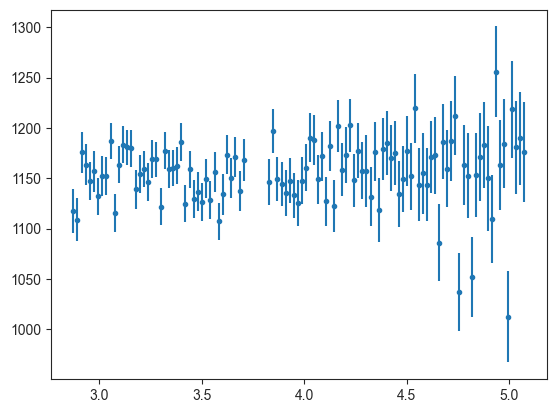

In [7]:
plt.errorbar(w776, d776, derr776, fmt = '.')

Resolution is, approx:

In [8]:
np.mean(w776) / np.nanmedian(np.diff(w776))

/Users/nespinoza/opt/anaconda3/envs/newen/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


199.52570754717408

Let's bin to 100:

In [9]:
w776, d776, derr776 = bin_at_resolution(w776, d776, depths_errors = derr776, R = 100)

<ErrorbarContainer object of 3 artists>

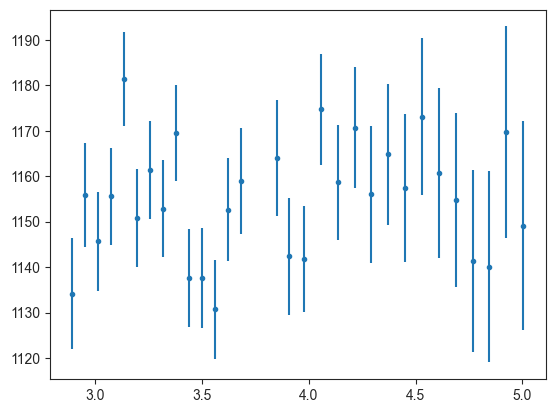

In [10]:
plt.errorbar(w776, d776, derr776, fmt = '.')

Nice, let's get it:

In [11]:
thedict['TOI-776 c'] = {}
thedict['TOI-776 c']['wavelength'] = w776
thedict['TOI-776 c']['depth'] = d776
thedict['TOI-776 c']['depth_errors'] = derr776

Save properties:

In [12]:
thedict['TOI-776 c']['planet mass'] = 6.90
thedict['TOI-776 c']['planet radius'] = 2.05
thedict['TOI-776 c']['planet teq'] = 420
thedict['TOI-776 c']['stellar teff'] = 3725
thedict['TOI-776 c']['stellar radius'] = 0.55

Convert to scale-height:

In [13]:
sh776, sherr776 = transit_depth_to_sh(d776, derr776, 
                                      thedict['TOI-776 c']['stellar radius'], 
                                      thedict['TOI-776 c']['planet mass'], 
                                      thedict['TOI-776 c']['planet teq'])

Estimated planet radius: 2.04 Rearth
Estimated gravity: 16.25 m/s2
Estimated scale-height: 78.65 km


<ErrorbarContainer object of 3 artists>

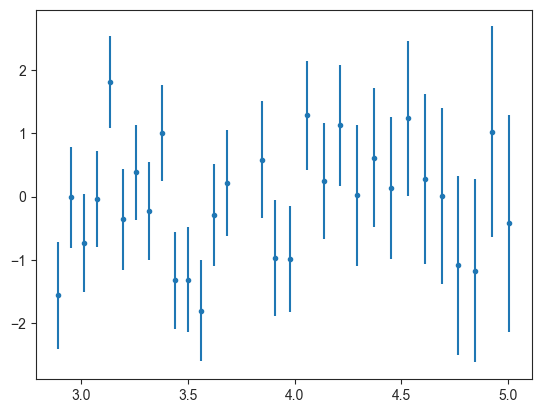

In [14]:
plt.errorbar(w776, sh776 - np.nanmedian(sh776), sherr776, fmt = '.')

Neat, save this median-normalized-to-scale-height spectrum:

In [15]:
thedict['TOI-776 c']['normalized_rp'] = sh776 - np.nanmedian(sh776)
thedict['TOI-776 c']['normalized_rp_errors'] = sherr776

## TOI-270 d

All right, next up, TOI-270d:

In [16]:
w270, d270, derr270 = np.loadtxt('raw-spectra/TOI-270d_nirspec_g395h_native_holmberg.txt', unpack = True, usecols = (0, 2, 3))

Bin native resolution to 100:

<ErrorbarContainer object of 3 artists>

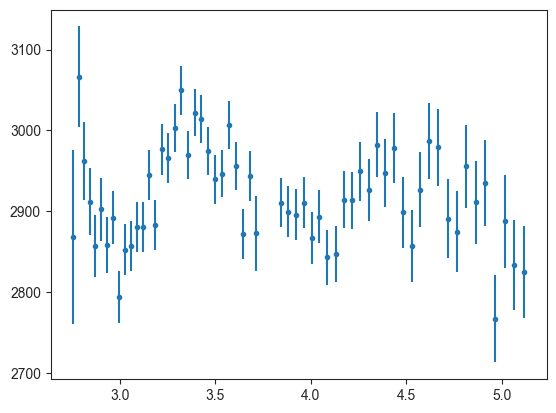

In [17]:
w270, d270, derr270 = bin_at_resolution(w270, d270*1e6, depths_errors = derr270*1e6, R = 100)
plt.errorbar(w270, d270, derr270, fmt = '.')

In [18]:
thedict['TOI-270 d'] = {}
thedict['TOI-270 d']['wavelength'] = w270
thedict['TOI-270 d']['depth'] = d270
thedict['TOI-270 d']['depth_errors'] = derr270

In [19]:
thedict['TOI-270 d']['planet mass'] = 4.78
thedict['TOI-270 d']['planet radius'] = 2.13
thedict['TOI-270 d']['planet teq'] = 387
thedict['TOI-270 d']['stellar teff'] = 3506
thedict['TOI-270 d']['stellar radius'] = 0.38

In [20]:
sh270, sherr270 = transit_depth_to_sh(d270, derr270, 
                                      thedict['TOI-270 d']['stellar radius'], 
                                      thedict['TOI-270 d']['planet mass'], 
                                      thedict['TOI-270 d']['planet teq'])

Estimated planet radius: 2.24 Rearth
Estimated gravity: 9.36 m/s2
Estimated scale-height: 125.83 km


<ErrorbarContainer object of 3 artists>

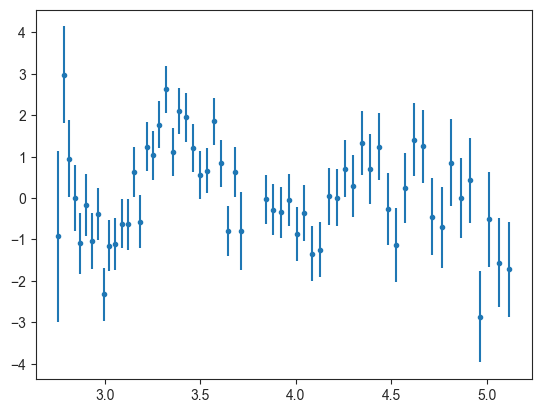

In [21]:
plt.errorbar(w270, sh270 - np.nanmedian(sh270), sherr270, fmt = '.')

In [22]:
thedict['TOI-270 d']['normalized_rp'] = sh270 - np.nanmedian(sh270)
thedict['TOI-270 d']['normalized_rp_errors'] = sherr270

## GJ 1214 b


In [23]:
w1214, d1214, derr1214 = np.loadtxt('raw-spectra/gj1214_schlawin.txt', unpack = True, usecols = (0, 2, 3))

What's the average resolution?

In [24]:
np.mean(w1214) / np.mean(np.diff(w1214))

32.71160069007984

<ErrorbarContainer object of 3 artists>

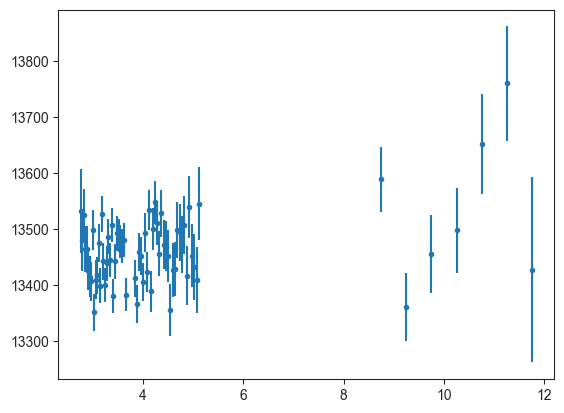

In [25]:
d1214, derr1214 = d1214*1e6, derr1214*1e6
plt.errorbar(w1214, d1214, derr1214, fmt = '.')

Ah, varies quite a bit. What about the resolution for spectra below 5.2 um:

In [26]:
idx = np.where(w1214<5.2)[0]

np.mean(w1214[idx]) / np.mean(np.diff(w1214[idx]))

94.58461138161103

Neat, already at R = 100. So let's keep as is:

<ErrorbarContainer object of 3 artists>

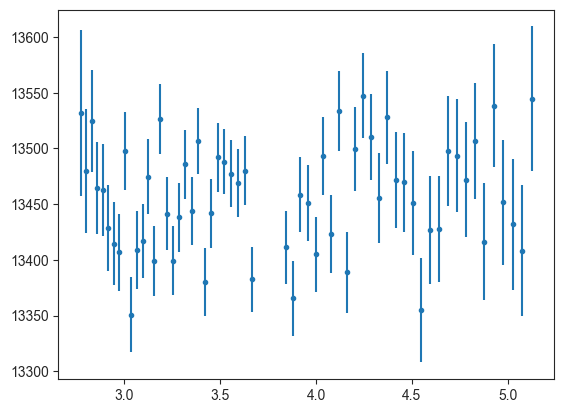

In [27]:
plt.errorbar(w1214[idx], d1214[idx], derr1214[idx], fmt = '.')

Let's only save this, by the way --- MIRI is great, but we want to compare accross subneptunes for illustration on the same wavelengths:

In [28]:
w1214, d1214, derr1214 = w1214[idx], d1214[idx], derr1214[idx]

In [29]:
thedict['GJ 1214 b'] = {}
thedict['GJ 1214 b']['wavelength'] = w1214
thedict['GJ 1214 b']['depth'] = d1214
thedict['GJ 1214 b']['depth_errors'] = derr1214

In [30]:
thedict['GJ 1214 b']['planet mass'] = 8.41
thedict['GJ 1214 b']['planet radius'] = 2.73
thedict['GJ 1214 b']['planet teq'] = 567
thedict['GJ 1214 b']['stellar teff'] = 3101
thedict['GJ 1214 b']['stellar radius'] = 0.22

In [31]:
sh1214, sherr1214 = transit_depth_to_sh(d1214, derr1214, 
                                      thedict['GJ 1214 b']['stellar radius'], 
                                      thedict['GJ 1214 b']['planet mass'], 
                                      thedict['GJ 1214 b']['planet teq'])

Estimated planet radius: 2.78 Rearth
Estimated gravity: 10.63 m/s2
Estimated scale-height: 162.31 km


<ErrorbarContainer object of 3 artists>

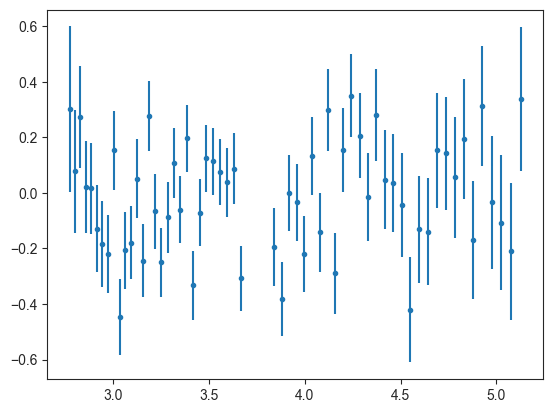

In [32]:
plt.errorbar(w1214, sh1214 - np.nanmedian(sh1214), sherr1214, fmt = '.')

In [33]:
thedict['GJ 1214 b']['normalized_rp'] = sh1214 - np.nanmedian(sh1214)
thedict['GJ 1214 b']['normalized_rp_errors'] = sherr1214

Neat (and wow for probing sub-scale-height for a sub-Neptune).

## GJ 9827 d

Let's go for GJ 9827 d:

In [34]:
w9827_l,w9827_u, d9827, derr9827_u, derr9827_l = np.loadtxt('raw-spectra/gj9827d_piaulet-ghorayeb.txt', unpack = True, usecols = (1, 2, 3, 4, 5))

In [35]:
w9827 = (w9827_l + w9827_u) * 0.5
derr9827 = ( derr9827_u + derr9827_l ) * 0.5

<ErrorbarContainer object of 3 artists>

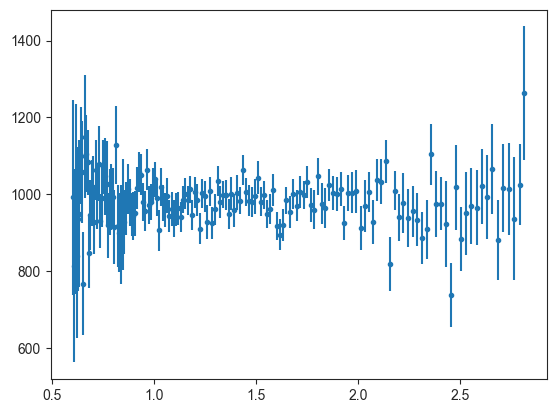

In [36]:
plt.errorbar(w9827, d9827, derr9827, fmt = '.')

Average resolution?

In [37]:
np.mean(w9827[idx]) / np.mean(np.diff(w9827[idx]))

100.68697202759418

Nice --- already at 100. Let's move forward:

In [38]:
thedict['GJ 9827 d'] = {}
thedict['GJ 9827 d']['wavelength'] = w9827
thedict['GJ 9827 d']['depth'] = d9827
thedict['GJ 9827 d']['depth_errors'] = derr9827

In [39]:
thedict['GJ 9827 d']['planet mass'] = 3.02
thedict['GJ 9827 d']['planet radius'] = 1.98
thedict['GJ 9827 d']['planet teq'] = 675
thedict['GJ 9827 d']['stellar teff'] = 4236
thedict['GJ 9827 d']['stellar radius'] = 0.60

In [40]:
sh9827, sherr9827 = transit_depth_to_sh(d9827, derr9827, 
                                      thedict['GJ 9827 d']['stellar radius'], 
                                      thedict['GJ 9827 d']['planet mass'], 
                                      thedict['GJ 9827 d']['planet teq'])

Estimated planet radius: 2.05 Rearth
Estimated gravity: 7.05 m/s2
Estimated scale-height: 291.24 km


/var/folders/y5/_ldk3z5d46qf_8jkyqk5trbw0002dd/T/ipykernel_52997/2794259782.py:26: RuntimeWarning: invalid value encountered in sqrt
  distribution = np.sqrt( np.random.normal(depths[i]*1e-6, depths_errors[i]*1e-6, 1000) )


<ErrorbarContainer object of 3 artists>

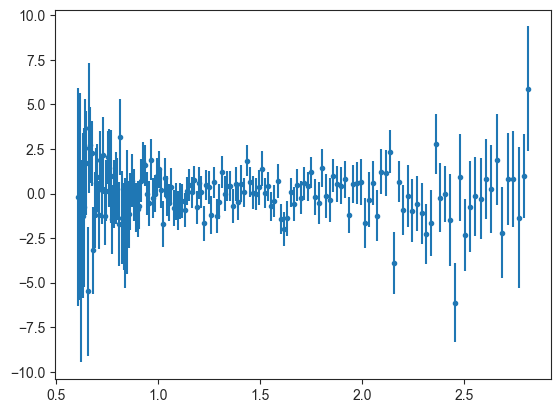

In [41]:
plt.errorbar(w9827, sh9827 - np.nanmedian(sh9827), sherr9827, fmt = '.')

In [42]:
thedict['GJ 9827 d']['normalized_rp'] = sh9827 - np.nanmedian(sh9827)
thedict['GJ 9827 d']['normalized_rp_errors'] = sherr9827

## K2-18 b

K2-18 b. First SOSS:

In [43]:
w18_soss, d18_soss, derr18_soss = np.loadtxt('raw-spectra/k2-18b_soss_madhu.txt', unpack = True, usecols = (0, 2, 3))

Bin to R=100:

<ErrorbarContainer object of 3 artists>

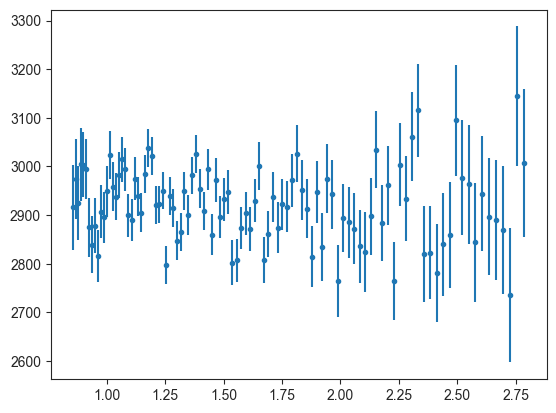

In [44]:
w18_soss, d18_soss, derr18_soss = bin_at_resolution(w18_soss, d18_soss*1e6, depths_errors = derr18_soss*1e6, R = 100)
plt.errorbar(w18_soss, d18_soss, derr18_soss, fmt = '.')

Same for G395H:

In [45]:
w18_nirspec, d18_nirspec, derr18_nirspec = np.loadtxt('raw-spectra/k2-18b_nirspec_madhu.txt', unpack = True, usecols = (0, 2, 3))

<ErrorbarContainer object of 3 artists>

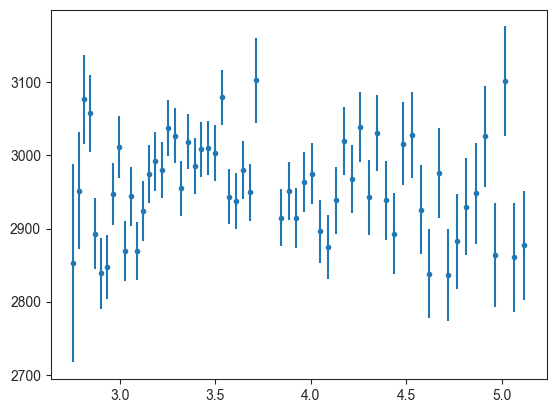

In [46]:
w18_nirspec, d18_nirspec, derr18_nirspec = bin_at_resolution(w18_nirspec, d18_nirspec*1e6, depths_errors = derr18_nirspec*1e6, R = 100)
plt.errorbar(w18_nirspec, d18_nirspec, derr18_nirspec, fmt = '.')

Stitch them:

In [47]:
w18, d18, derr18 = np.append(w18_soss, w18_nirspec), \
                   np.append(d18_soss, d18_nirspec), \
                   np.append(derr18_soss, derr18_nirspec)

<ErrorbarContainer object of 3 artists>

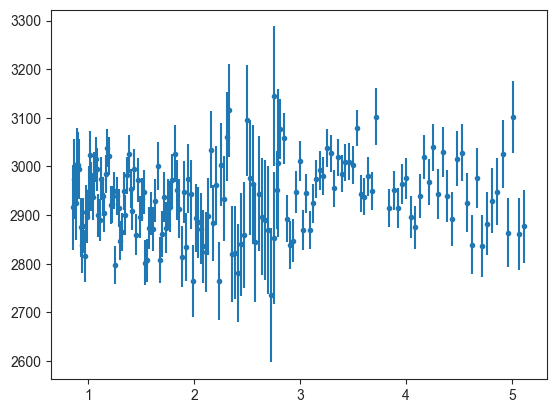

In [48]:
plt.errorbar(w18, d18, derr18, fmt = '.')

Yay! Let's save:

In [49]:
thedict['K2-18 b'] = {}
thedict['K2-18 b']['wavelength'] = w18
thedict['K2-18 b']['depth'] = d18
thedict['K2-18 b']['depth_errors'] = derr18

In [50]:
thedict['K2-18 b']['planet mass'] = 8.92
thedict['K2-18 b']['planet radius'] = 2.37
thedict['K2-18 b']['planet teq'] = 284
thedict['K2-18 b']['stellar teff'] = 3457
thedict['K2-18 b']['stellar radius'] = 0.44

In [51]:
sh18, sherr18 = transit_depth_to_sh(d18, derr18, 
                                    thedict['K2-18 b']['stellar radius'], 
                                    thedict['K2-18 b']['planet mass'], 
                                    thedict['K2-18 b']['planet teq'])

Estimated planet radius: 2.60 Rearth
Estimated gravity: 12.92 m/s2
Estimated scale-height: 66.92 km


<ErrorbarContainer object of 3 artists>

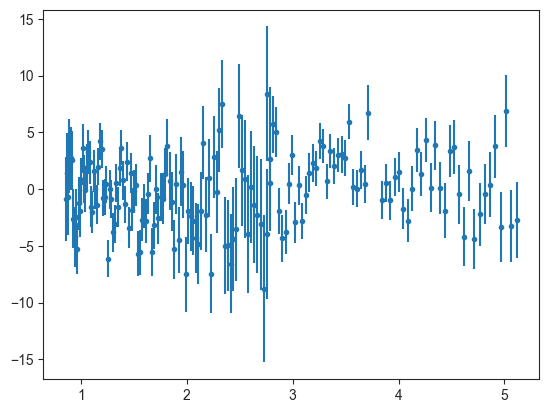

In [52]:
plt.errorbar(w18, sh18 - np.nanmedian(sh18), sherr18, fmt = '.')

In [53]:
thedict['K2-18 b']['normalized_rp'] = sh18 - np.nanmedian(sh18)
thedict['K2-18 b']['normalized_rp_errors'] = sherr18

## TOI-836 c

Finally, TOI-836 c:

In [54]:
w836, d836, derr836_up, derr836_low = np.loadtxt('raw-spectra/table_TOI-836-c-Wallack-et-al.-2024.tbl', unpack = True, usecols = (0, 1, 2, 3))

In [55]:
derr836 = (derr836_up + np.abs(derr836_low))*0.5

In [56]:
d836, derr836 = d836*1e4, derr836*1e4

<ErrorbarContainer object of 3 artists>

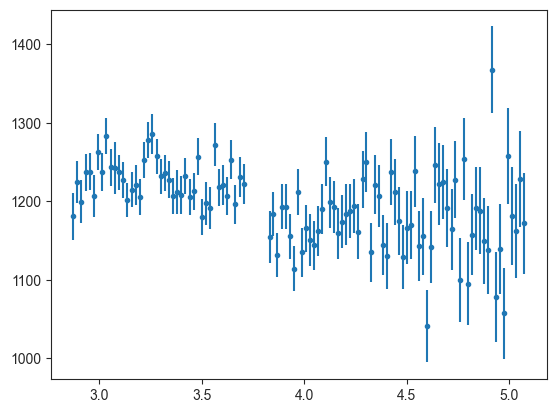

In [57]:
plt.errorbar(w836, d836, derr836, fmt = '.')

Average resolution?

In [58]:
np.mean(w836) / np.mean(np.diff(w836))

190.54229195088678

OK, bin to 100:

In [59]:
w836, d836, derr836 = bin_at_resolution(w836, d836, depths_errors = derr836, R = 100)

<ErrorbarContainer object of 3 artists>

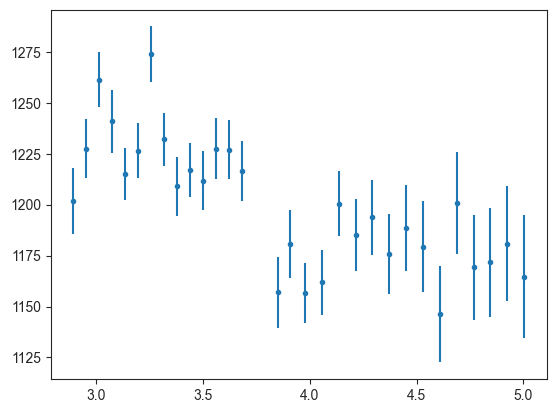

In [60]:
plt.errorbar(w836, d836, derr836, fmt = '.')

In [61]:
thedict['TOI-836 c'] = {}
thedict['TOI-836 c']['wavelength'] = w836
thedict['TOI-836 c']['depth'] = d836
thedict['TOI-836 c']['depth_errors'] = derr836

In [62]:
thedict['TOI-836 c']['planet mass'] = 9.60
thedict['TOI-836 c']['planet radius'] = 2.59
thedict['TOI-836 c']['planet teq'] = 665
thedict['TOI-836 c']['stellar teff'] = 4552
thedict['TOI-836 c']['stellar radius'] = 0.67

In [63]:
sh836, sherr836 = transit_depth_to_sh(d836, derr836, 
                                    thedict['TOI-836 c']['stellar radius'], 
                                    thedict['TOI-836 c']['planet mass'], 
                                    thedict['TOI-836 c']['planet teq'])

Estimated planet radius: 2.53 Rearth
Estimated gravity: 14.67 m/s2
Estimated scale-height: 137.93 km


<ErrorbarContainer object of 3 artists>

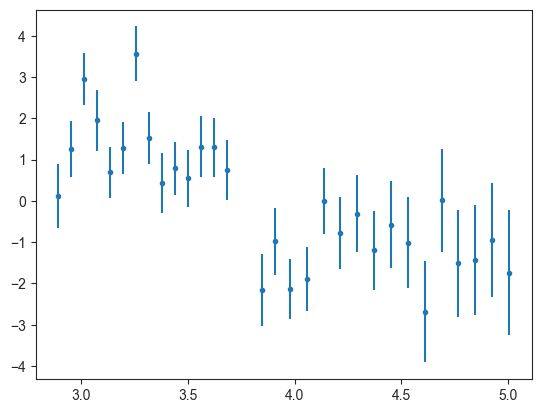

In [64]:
plt.errorbar(w836, sh836 - np.nanmedian(sh836), sherr836, fmt = '.')

In [65]:
thedict['TOI-836 c']['normalized_rp'] = sh836 - np.nanmedian(sh836)
thedict['TOI-836 c']['normalized_rp_errors'] = sherr836

Let's list all the properties of the exoplanets in the dictionary:

In [66]:
for planet in list(thedict.keys()):

    print(planet, 'Mp: {0:.2f}, Rp: {1:.2f}, Teq: {2:.2f} '.format(thedict[planet]['planet mass'], thedict[planet]['planet radius'], thedict[planet]['planet teq']))

TOI-776 c Mp: 6.90, Rp: 2.05, Teq: 420.00 
TOI-270 d Mp: 4.78, Rp: 2.13, Teq: 387.00 
GJ 1214 b Mp: 8.41, Rp: 2.73, Teq: 567.00 
GJ 9827 d Mp: 3.02, Rp: 1.98, Teq: 675.00 
K2-18 b Mp: 8.92, Rp: 2.37, Teq: 284.00 
TOI-836 c Mp: 9.60, Rp: 2.59, Teq: 665.00 


Nice. There's a nice sequence in temperature --- similar radius, but very different masses.

Let's save this dictionary:

In [67]:
import os

In [68]:
# File name for the pickle file
filename = 'sub-neptune-jwst-spectra.pkl'

if not os.path.exists(filename):
    
    # Save the data to the pickle file
    with open(filename, 'wb') as file:
        pickle.dump(thedict, file)

# 3. Forward modelling

All right, as part of this excercise, we want to plot some forward models along with the data. We use `POSEIDON` for this. First, define a couple of handy-dandy functions and classes:

In [69]:
from POSEIDON.core import create_star, create_planet, define_model, make_atmosphere, read_opacities, wl_grid_constant_R, compute_spectrum
from POSEIDON.constants import R_Sun, R_E, M_E 

[rakisduam.stsci.edu:52997] shmem: mmap: an error occurred while determining whether or not /var/folders/y5/_ldk3z5d46qf_8jkyqk5trbw0002dd/T//ompi.rakisduam.2477/jf.0/3695378432/sm_segment.rakisduam.2477.dc430000.0 could be created.


In [70]:
from POSEIDON.supported_chemicals import supported_species

In [71]:
supported_species

array(['H2O', 'CO2', 'CH4', 'CO', 'Na', 'K', 'NH3', 'HCN', 'SO2', 'H2S',
       'PH3', 'C2H2', 'OCS', 'TiO', 'VO', 'AlO', 'SiO', 'CaO', 'MgO',
       'NaO', 'LaO', 'ZrO', 'SO', 'NO', 'PO', 'TiH', 'CrH', 'FeH', 'ScH',
       'AlH', 'SiH', 'BeH', 'CaH', 'MgH', 'LiH', 'NaH', 'OH', 'OH+', 'CH',
       'NH', 'SH', 'PN', 'PS', 'CS', 'C2', 'CH3', 'H3+', 'N2O', 'NO2',
       'C2H4', 'C2H6', 'CH3CN', 'CH3OH', 'GeH4', 'CS2', 'O2', 'O3', 'Al',
       'Ba', 'Ba+', 'Ca', 'Ca+', 'Cr', 'Cs', 'Fe', 'Fe+', 'Li', 'Mg',
       'Mg+', 'Mn', 'Ni', 'O', 'Rb', 'Sc', 'Ti', 'Ti+', 'V', 'V+'],
      dtype='<U5')

In [72]:
import POSEIDON

In [73]:
from scipy.ndimage import gaussian_filter

In [81]:
class generate_atmosphere:

    def set_parameters(self, T, log_X, cloud_parameters, P_ref = None):

        if P_ref is None:

            P_ref = self.P_ref

        self.T = T
        self.log_X = log_X
        self.cloud_parameters = cloud_parameters

        PT_params = np.array([T])

        self.atmosphere = make_atmosphere(self.planet, self.model, self.P, P_ref, self.R_p_ref,
                                          PT_params, log_X,  cloud_params=cloud_parameters)

    def get_spectrum(self):

        return compute_spectrum(self.planet, self.star, self.model, self.atmosphere, self.opac, self.wl,
                                spectrum_type = 'transmission')

    def __init__(self, star_properties, planet_properties, param_species, bulk_species,
                 PT_profile = 'isotherm', cloud_model = 'MacMad17', cloud_type = 'deck_haze', cloud_dim = 1,
                 P_min = 1e-7, P_max = 100, N_layers = 100, P_surf = 100.0, wl_min = 0.5, wl_max = 5.7, R = 10000,
                 planet_name = 'myplanet', model_name = 'mymodel'):

        # Load stellar properties:
        self.R_s = star_properties['R'] * R_Sun
        self.T_s = star_properties['Teff']
        self.Met_s = star_properties['FeH']
        self.log_g_s = star_properties['logg']

        # Load planet properties:
        self.R_p = planet_properties['R'] * R_E
        self.M_p = planet_properties['M'] * M_E
        self.T_eq = planet_properties['T_eq']

        # Save parameters for posteriety:
        self.param_species = param_species
        self.bulk_species = bulk_species

        # Create star and planet:
        self.star = create_star(self.R_s, self.T_s, self.log_g_s, self.Met_s)
        self.planet = create_planet(planet_name, self.R_p, mass = self.M_p, T_eq = self.T_eq)


        self.model = define_model(model_name, bulk_species, param_species,
                                  PT_profile = PT_profile,
                                  cloud_model = cloud_model,
                                  cloud_type = cloud_type,
                                  cloud_dim = cloud_dim)

        self.wl = wl_grid_constant_R(wl_min, wl_max, R)

        # Read opacity:
        opacity_treatment = 'opacity_sampling'

        # Define fine temperature grid (K)
        T_fine_min = 100     # 100 K lower limit covers the TRAPPIST-1e P-T profile
        T_fine_max = 1000     # 300 K upper limit covers the TRAPPIST-1e P-T profile
        T_fine_step = 10     # 10 K steps are a good tradeoff between accuracy and RAM

        T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

        # Define fine pressure grid (log10(P/bar))
        log_P_fine_min = -6.0   # 1 ubar is the lowest pressure in the opacity database
        log_P_fine_max = 2.0    # 1 bar is the surface pressure, so no need to go deeper
        log_P_fine_step = 0.2   # 0.2 dex steps are a good tradeoff between accuracy and RAM

        log_P_fine = np.arange(log_P_fine_min, (log_P_fine_max + log_P_fine_step), log_P_fine_step)

        self.opac = read_opacities(self.model, self.wl, opacity_treatment, T_fine, log_P_fine)#, opacity_database = 'Temperate')

        # Set atmosphere --- first, set initial values:
        self.P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)
        self.P_ref = P_surf
        self.R_p_ref = self.R_p

        T_init = 300.
        # this sets by hand the number of opacities --- FIXME to generalize inputs:
        log_X_init = np.log10( np.array([0.1, 0.1, 0.1, 0.1]) )
        a, Pcloud = 1., 1e6
        log_a, gamma, log_P_cloud = np.log10(a), -4., np.log10(Pcloud)
        self.log_a, self.gamma, self.log_P_cloud = np.log10(a), -4., np.log10(Pcloud)

        cloud_params_init = [self.log_a, self.gamma, self.log_P_cloud]

        self.set_parameters(T_init, log_X_init, cloud_params_init)

In [82]:
def bin_to_data(w_data, w_model, d_model):

    d_data = np.zeros(len(w_data))

    # Assume data is argsorted:
    for i in range(len(w_data)):

        if i == 0.: 

            delta_w = w_data[1] - w_data[0]

        else:

            delta_w = w_data[i] - w_data[i-1]

        idx = np.where(np.abs(w_data[i]-w_model) <= delta_w)[0]

        d_data[i] = np.mean( d_model[idx] )

    return d_data

The above is a setup for a simplified atmosphere. Giving a dominating gas, it allows for 3 mixing ratios (which we'll use for H2O, CH4 and CO2). 

Let's start setting this up for TOI-270 d. 

## 3.1 Mini grid-modelling for TOI-270 d

Define properties:

In [199]:
# Define star/planet atmospheric properties:
star_properties = {}

star_properties['R'] =  thedict['TOI-270 d']['stellar radius']
star_properties['Teff'] = thedict['TOI-270 d']['stellar teff']
star_properties['FeH'] = 0.0
star_properties['logg'] = 4.5

planet_properties = {}

planet_properties['R'] = thedict['TOI-270 d']['planet radius'] # Rearth
planet_properties['M'] = thedict['TOI-270 d']['planet mass']
planet_properties['T_eq'] = thedict['TOI-270 d']['planet teq']

# Atmosphere is hydrogen-dominated by default:
bulk_species = ['H2']
param_species = ['CO2', 'CH4', 'H2O', 'CS2']

# Haze properties fixed:
log_a, gamma = np.log10(1.), -4

Generate an initial atmosphere so we can iterate through it:

In [200]:
planet = generate_atmosphere(star_properties, planet_properties, param_species, bulk_species, R = 500)
wavelengths_model = planet.wl

Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-CH4 done
CO2-H2 done
CO2-CO2 done
CO2-CH4 done
CO2 done
CH4 done
H2O done
CS2 done
Opacity pre-interpolation complete.


All right. Now, let's define a set of log-mixing ratios, temperatures, and pressures so we can generate forward models that we can then compare to the data. Note we also fit for an offset between NRS1 and NRS2 (< 3.8 and above 3.8 um):

In [201]:
nmodels = 1000
models = np.zeros([nmodels, len(wavelengths_model)])
bmodels = np.zeros([nmodels, len(thedict['TOI-270 d']['wavelength'])])
residuals = np.zeros(nmodels)
parameters = []

In [203]:
idx_offset_models = np.where( wavelengths_model > 3.8 )[0]
idx_offset_data = np.where( thedict['TOI-270 d']['wavelength'] > 3.8 )[0]
for i in range(nmodels):

    # Sample offset we add/subtract to the models on NRS2:
    offset = np.random.uniform(-200,200)
                      
    # Sample log mixing ratios between -5 and -1:
    logCO2, logCH4, logH2O, logCS2 = np.random.uniform(-8, -1, 4)

    # Sample temperature between 200 and 1000:
    T = np.random.uniform(thedict['TOI-270 d']['planet teq']-100, thedict['TOI-270 d']['planet teq']+100)

    # Sample cloud-top pressures and P_ref between -6 and 2 in log:
    logPcloud, logP_ref = np.random.uniform(-6, 2, 2)

    # Evaluate model:
    log_X = np.array([logCO2, logCH4, logH2O, logCS2])
    P_ref = 10**(logP_ref)

    planet.set_parameters(T, log_X, [log_a, gamma, logPcloud], P_ref = P_ref)

    parameters.append([log_X, logPcloud, logP_ref, T, offset])
    models[i, :] = planet.get_spectrum() * 1e6
    models[i, :] = gaussian_filter(median_filter(models[i, :],10), 2)

    # bin to data:
    bmodels[i, :] = bin_to_data(thedict['TOI-270 d']['wavelength'], wavelengths_model, models[i, :])

    # make it insensitive to an _overall_ offset:
    bs = bmodels[i, :] - np.mean(bmodels[i, :])
    data_offset = thedict['TOI-270 d']['depth'] - np.mean(thedict['TOI-270 d']['depth'])
    data_offset[idx_offset_data] += offset
    
    # Get residuals:
    residuals[i] = np.sum( np.abs( bs - data_offset ) )

Check minimum residuals model:

In [204]:
idx = np.where( residuals == np.min(residuals))[0]

(3.0, 5.1)

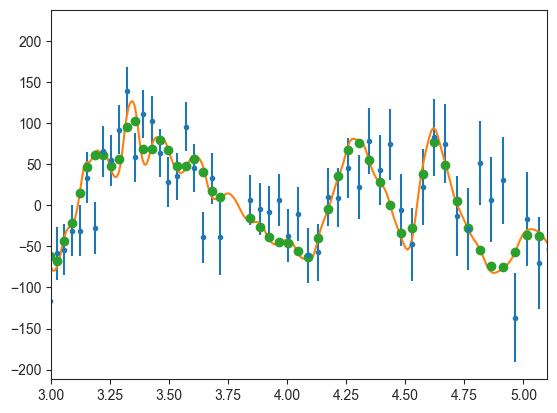

In [208]:
opt_parameters = parameters[idx[0]]

data_offset = thedict['TOI-270 d']['depth'] - np.nanmedian( thedict['TOI-270 d']['depth'] )
data_offset[idx_offset_data] += opt_parameters[-1] 

plt.errorbar(thedict['TOI-270 d']['wavelength'], 
             data_offset, 
             thedict['TOI-270 d']['depth_errors'], fmt = '.')

plt.plot(wavelengths_model, models[idx, :][0,:] - np.nanmedian( bmodels[idx, :] ))
plt.plot(thedict['TOI-270 d']['wavelength'], bmodels[idx, :][0,:] - np.nanmedian( bmodels[idx, :] ), 'o')

plt.xlim(3, 5.1)

In [207]:
opt_parameters[-1]

6.790847155500401

Nice! It works. 

## 3.2 Mini grid-modelling for all planets

Let's repeat the excercise for all the spectra accross the board via a for loop that repeats the excercise, and saves model results into a dictionary:

In [229]:
planets = list( thedict.keys() )

Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-CH4 done
CO2-H2 done
CO2-CO2 done
CO2-CH4 done
CO2 done
CH4 done
H2O done
CS2 done
Opacity pre-interpolation complete.


<Figure size 640x480 with 0 Axes>

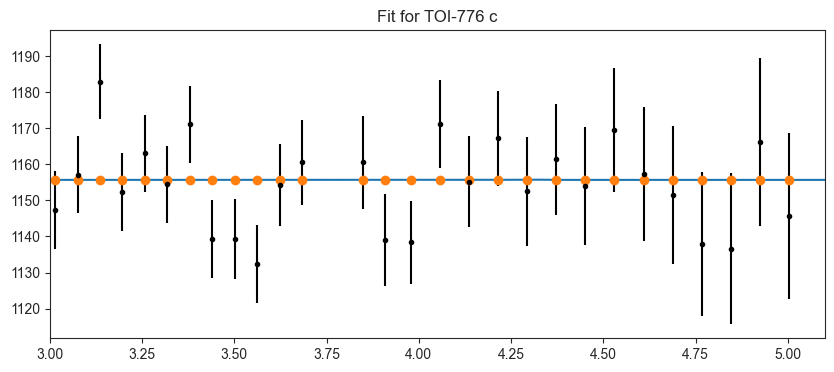

Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-CH4 done
CO2-H2 done
CO2-CO2 done
CO2-CH4 done
CO2 done
CH4 done
H2O done
CS2 done
Opacity pre-interpolation complete.


<Figure size 640x480 with 0 Axes>

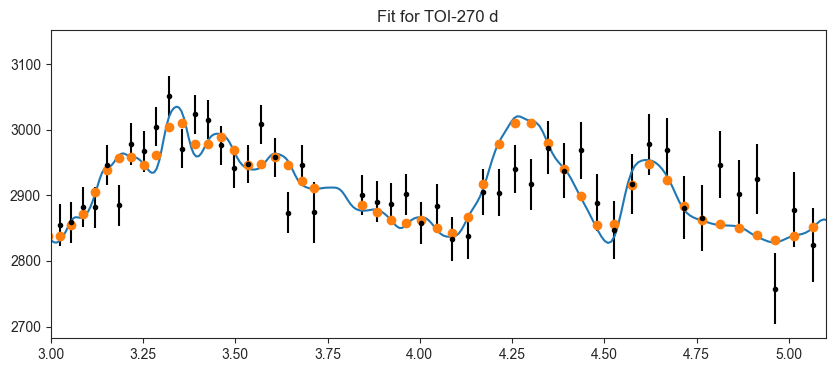

Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-CH4 done
CO2-H2 done
CO2-CO2 done
CO2-CH4 done
CO2 done
CH4 done
H2O done
CS2 done
Opacity pre-interpolation complete.


<Figure size 640x480 with 0 Axes>

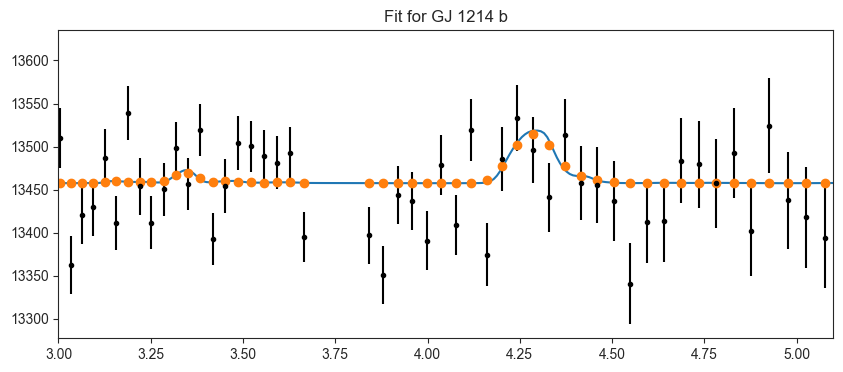

Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-CH4 done
CO2-H2 done
CO2-CO2 done
CO2-CH4 done
CO2 done
CH4 done
H2O done
CS2 done
Opacity pre-interpolation complete.


<Figure size 640x480 with 0 Axes>

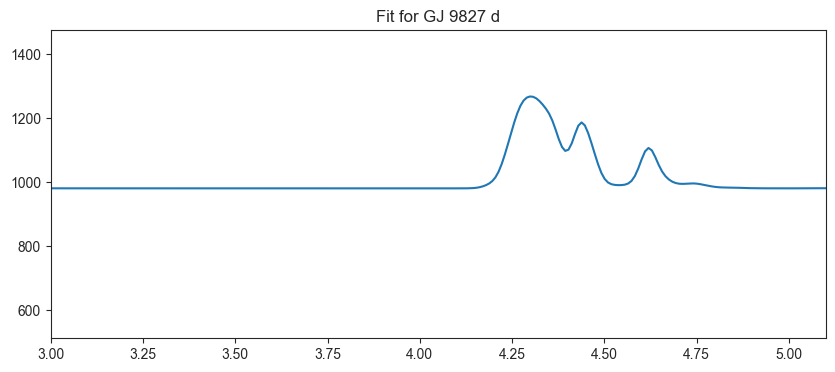

Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-CH4 done
CO2-H2 done
CO2-CO2 done
CO2-CH4 done
CO2 done
CH4 done
H2O done
CS2 done
Opacity pre-interpolation complete.


<Figure size 640x480 with 0 Axes>

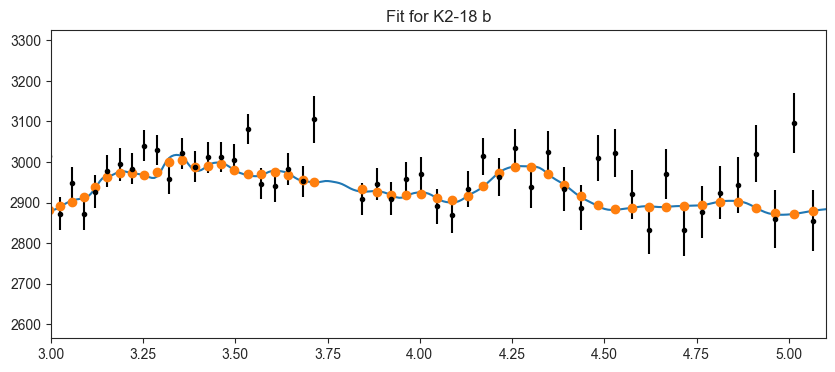

Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-CH4 done
CO2-H2 done
CO2-CO2 done
CO2-CH4 done
CO2 done
CH4 done
H2O done
CS2 done
Opacity pre-interpolation complete.


<Figure size 640x480 with 0 Axes>

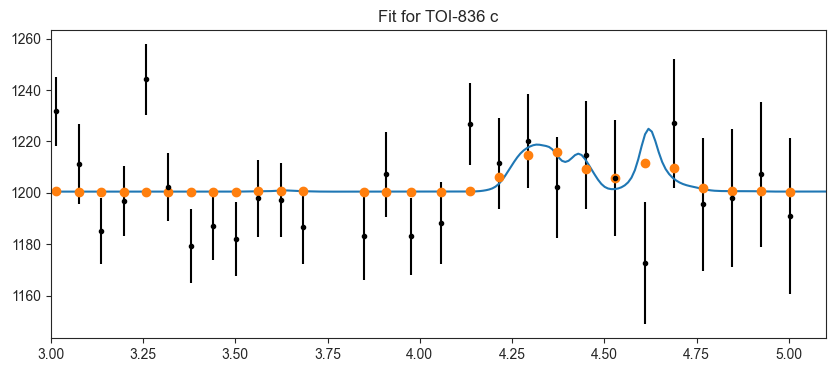

In [232]:
results = {}

nmodels = 100000
# Atmosphere is hydrogen-dominated by default:
bulk_species = ['H2']
param_species = ['CO2', 'CH4', 'H2O', 'CS2']
    
# Haze properties fixed:
log_a, gamma = np.log10(1.), -4

for planet_name in planets:

    # Define star/planet atmospheric properties:
    star_properties = {}
    
    star_properties['R'] =  thedict[planet_name]['stellar radius']
    star_properties['Teff'] = thedict[planet_name]['stellar teff']
    star_properties['FeH'] = 0.0
    star_properties['logg'] = 4.5
    
    planet_properties = {}
    
    planet_properties['R'] = thedict[planet_name]['planet radius'] # Rearth
    planet_properties['M'] = thedict[planet_name]['planet mass']
    planet_properties['T_eq'] = thedict[planet_name]['planet teq']

    planet = generate_atmosphere(star_properties, planet_properties, param_species, bulk_species, R = 500)
    wavelengths_model = planet.wl
    
    models = np.zeros([nmodels, len(wavelengths_model)])
    bmodels = np.zeros([nmodels, len(thedict[planet_name]['wavelength'])])
    residuals = np.zeros(nmodels)
    parameters = []

    idx_offset_models = np.where( wavelengths_model > 3.8 )[0]
    idx_offset_data_nrs1 = np.where( thedict[planet_name]['wavelength'] < 3.8 )[0]
    idx_offset_data_nrs2 = np.where( thedict[planet_name]['wavelength'] > 3.8 )[0]

    for i in range(nmodels):

        # Sample offset we add/subtract to the models on NRS2:
        offset1, offset2 = np.random.uniform(-200,200,2)
    
        # Sample log mixing ratios between -5 and -1:
        logCO2, logCH4, logH2O, logCS2 = np.random.uniform(-8, -1, 4)
    
        # Sample around 200 K in temperature from teq --- with a minimum of 100 K and max of 1000 K:
        min_T = np.max([thedict[planet_name]['planet teq']-200, 100])
        max_T = np.min([thedict[planet_name]['planet teq']+200, 1000])
        T = np.random.uniform(min_T, max_T)
    
        # Sample cloud-top pressures and P_ref between -6 and 2 in log:
        logPcloud, logP_ref = np.random.uniform(-6, 2, 2)
    
        # Evaluate model:
        log_X = np.array([logCO2, logCH4, logH2O, logCS2])
        P_ref = 10**(logP_ref)
    
        planet.set_parameters(T, log_X, [log_a, gamma, logPcloud], P_ref = P_ref)
    
        parameters.append([log_X, logPcloud, logP_ref, T, offset1, offset2])
        models[i, :] = planet.get_spectrum() * 1e6
        models[i, :] = gaussian_filter(median_filter(models[i, :],10), 2)
    
        # bin to data:
        bmodels[i, :] = bin_to_data(thedict[planet_name]['wavelength'], wavelengths_model, models[i, :])        
        
        # make it insensitive to offset:
        bs = bmodels[i, :] - np.nanmean(bmodels[i, :])
        data_offset = thedict[planet_name]['depth'] - np.nanmean(thedict[planet_name]['depth'])
        data_offset[idx_offset_data_nrs1] += offset1
        data_offset[idx_offset_data_nrs2] += offset2
        
        # Get residuals:
        residuals[i] = np.nansum( np.abs( bs - data_offset ) )

    plt.clf()
    
    plt.figure(figsize=(10,4))
    plt.title('Fit for '+planet_name)
    idx = np.where( residuals == np.min(residuals))[0]
    opt_offset1 = parameters[idx[0]][-2]
    opt_offset2 = parameters[idx[0]][-1]
    plt.errorbar(thedict[planet_name]['wavelength'][idx_offset_data_nrs1], 
                 thedict[planet_name]['depth'][idx_offset_data_nrs1] + opt_offset1, 
                 thedict[planet_name]['depth_errors'][idx_offset_data_nrs1], fmt = '.', color = 'black')

    plt.errorbar(thedict[planet_name]['wavelength'][idx_offset_data_nrs2], 
                 thedict[planet_name]['depth'][idx_offset_data_nrs2] + opt_offset2, 
                 thedict[planet_name]['depth_errors'][idx_offset_data_nrs2], fmt = '.', color = 'black')
    
    plt.plot(wavelengths_model, models[idx, :][0,:] - np.nanmedian( bmodels[idx, :] ) + np.nanmedian( thedict[planet_name]['depth'] ))
    plt.plot(thedict[planet_name]['wavelength'], bmodels[idx, :][0,:] - np.nanmedian( bmodels[idx, :] ) + np.nanmedian( thedict[planet_name]['depth'] ), 'o')
    
    plt.xlim(3, 5.1)
    plt.show()

    # Save results:
    results[planet_name] = {}
    results[planet_name]['NRS1 offset'] = opt_offset1
    results[planet_name]['NRS2 offset'] = opt_offset2
    results[planet_name]['model wavelength'] = np.copy(wavelengths_model)
    results[planet_name]['model best fit'] = models[idx, :][0,:] - np.nanmedian( bmodels[idx, :] ) + np.nanmedian( thedict[planet_name]['depth'] )
    results[planet_name]['binned best fit'] = bmodels[idx, :][0,:] - np.nanmedian( bmodels[idx, :] ) + np.nanmedian( thedict[planet_name]['depth'] )
    results[planet_name]['parameters best fit'] = parameters[idx[0]]
    results[planet_name]['residuals'] = np.copy(residuals)
    results[planet_name]['all models'] = np.copy(models)
    results[planet_name]['all binned models'] = np.copy(bmodels)
    results[planet_name]['all parameters'] = parameters.copy()



And now save those results:

In [235]:
# File name for the pickle file
filename = 'sub-neptune-jwst-model-spectra.pkl'

if not os.path.exists(filename):
    
    # Save the data to the pickle file
    with open(filename, 'wb') as file:
        pickle.dump(results, file)

In [236]:
all_offsets = np.zeros(len(parameters))

In [237]:
for i in range(len(parameters)):

    all_offsets[i] = parameters[i][-1]

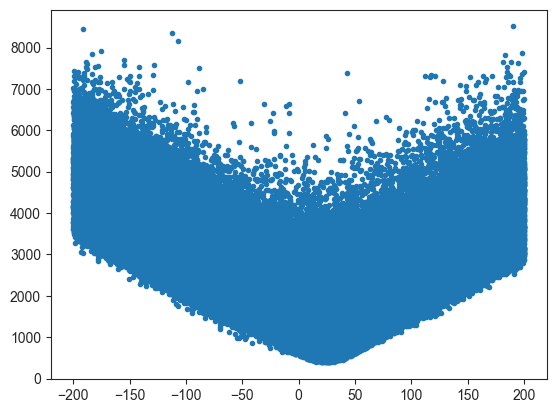

In [238]:
plt.plot(all_offsets, residuals, '.')

In [240]:
for planet_name in planets:

    print(planet_name,'offsets:',results[planet_name]['NRS1 offset'],results[planet_name]['NRS2 offset'])

TOI-776 c offsets: 1.6564435910967568 -3.4171337000231894
TOI-270 d offsets: 1.4079199925376873 -9.594767866349674
GJ 1214 b offsets: 12.338377822377833 -14.082331778859736
GJ 9827 d offsets: -5.006819627256753 57.786500771235126
K2-18 b offsets: 2.5974141146088314 -5.355367765224095
TOI-836 c offsets: -29.655832282103223 26.36306600290723
